In [1]:
import numpy as np
import random
from math import log
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import re
 
#inputs 
D = 472 # number of documents
K = 10 # number of topics    

#computed
vocab = set()
docs = []
docs_i = None
civk = None
Cvk = None
Cik = None
V = None
qs = None
 
# open each file; convert everything to lowercase and strip non-letter symbols; split into words
for fileind in range( 1, D+1 ):
    foo = open( 'files/output%04d.txt' % fileind ).read()    
    tmp = re.sub( '[^a-z ]+', ' ', foo.lower() ).split()
    docs.append( tmp )
 
    for w in tmp:
        vocab.add( w )

# vocab now has unique words
# give each word in the vocab a unique id
ind = 0
vhash = {}
vindhash = {}
for i in list(vocab):
    vhash[i] = ind
    vindhash[ind] = i
    ind += 1

# size of our vocabulary
V = ind
 
# reprocess each document and re-represent it as a list of word ids
docs_i = []
for d in docs:
    dinds = []
    for w in d:
        dinds.append( vhash[w] )
    docs_i.append( dinds )

/Users/jacobbrewer/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def randomly_assign_topics(docs_i, K): #we do not know what the topic is at the beginning, we are randomly assigning a topic from 0 to 9 to each word in a doc
    q=[]
    for i in range(0, D,1):# for each doc
        assignment = []
        for j in range(len(docs_i[i])): # for each word in the doc
            assignment.append(np.random.randint(K)) #K OR K-1 # give the word a random topic assignment
        q.append(assignment)
        #print q
    return q

qs = randomly_assign_topics( docs_i, K ) # List[lists] 472


In [3]:
#Initialize civk
Isize = D #docs
Vsize = V #vocabulary
Ksize = K #topic size
civk = np.zeros((Isize,Vsize,Ksize))
Cvk = None
Cik = None
print "civk shape: ", civk.shape


for i in range(0,D,1):
    for l in range(0,len(docs_i[i]),1):
        #print i, l
        k = qs[i][l] #k = topics[l][i] 
        v = docs_i[i][l]
        civk[i][v][k] += 1

civk shape:  (472, 17675, 10)


In [4]:
def resamplePdtm(Cik,alphas):
    newPdtm = None
    for docIndex in range(0,len(Cik),1):
        pdtmCol = np.random.dirichlet((Cik[docIndex] + alphas), 1).T
        if (newPdtm == None):
            newPdtm = pdtmCol
        else:
            newPdtm = np.concatenate((newPdtm, pdtmCol), axis=1)
    return newPdtm

"""
def resamplePdtm2():
    cik = np.sum(civk, axis=1)
    for i in xrange(len(pdtm)):
        pdtm[:, i] = np.random.dirichlet((alphas + cik[i, :]))
    return pdtm

def resampleTopics2():
    cvk = np.sum(civk, axis=0)
    for i in xrange(len(pdtm)):
        pdtm[:, i] = np.random.dirichlet((alphas + cik[i, :]))
    return pdtm
"""

def resampleTopics(Cvk,gammas):
    newTopics = None
    for topicIndex in range(0,len(Cvk[0]),1):
        topicCol = np.random.dirichlet((Cvk[:,topicIndex] + gammas), 1).T
        if (newTopics == None):
            newTopics = topicCol
        else:
            newTopics = np.concatenate((newTopics, topicCol), axis=1)
        #print topicIndex, newTopics.shape
    return newTopics



In [5]:
def genCIK(civk):
    return np.sum(civk, axis=1)

def genCVK(civk):
    return np.sum(civk, axis=0)

print genCIK(civk).shape
print genCVK(civk).shape


(472, 10)
(17675, 10)


In [6]:
def compute_data_likelihood(docs_i, qs, topics, pdtm):
    ll = 0
    for i in xrange(len(docs_i)):
        for j_ind in xrange(len(docs_i[i])):
            ll += log(topics[docs_i[i][j_ind], qs[i][j_ind]])
    return ll

In [7]:
def resample_qs(qs, topics, pdtm):
    for i, doc in enumerate(docs_i):
        for l, v in enumerate(doc):
            
            tmp = []
            
            # probability of assignment to each topic
            for k in xrange(K):
                tmp.append(pdtm[k, i] * topics[v, k])
    
            # normalize probabilities so they sum to 1
            tmp = np.array(tmp)
            tmp = tmp / (float)(np.sum(tmp))
            
            # choose one of the topics using the probabilities
            prev = qs[i][l]
            qs[i][l] = np.random.choice(K, p = tmp)
            
            # update counts
            civk[i, docs_i[i][l], prev] -= 1
            civk[i, docs_i[i][l], qs[i][l]] += 1
            
    return qs

In [8]:
def visualizePDTM(pdtm):
    fig2 = plt.figure("Per Document Topic Mixtures", figsize=(19, 5))
    ax2 = fig2.add_subplot(111)
    ax2.set_xlabel("Documents")
    ax2.set_ylabel("Topic")
    cax2 = ax2.matshow(pdtm, aspect='auto', cmap = plt.cm.jet, origin='lower')
    ax2.grid('off')
    ax2.xaxis.set_ticks_position('bottom')
    fig2.colorbar(cax2)
    plt.show()

/Users/jacobbrewer/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/jacobbrewer/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:29: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


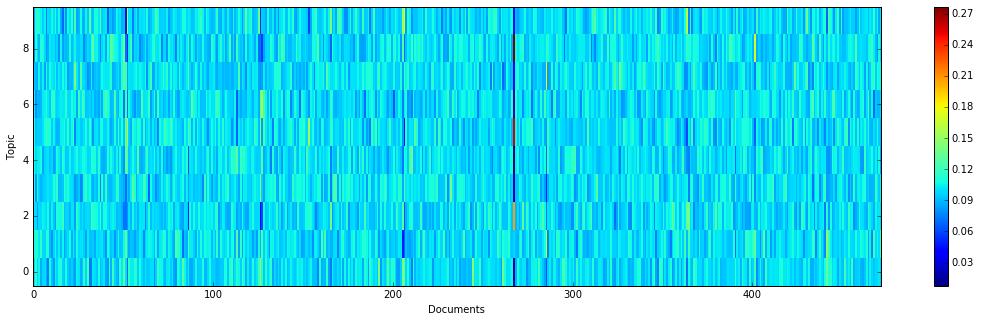

Iter 0, p=-5344404.98
Iter 1, p=-5328143.76
Iter 2, p=-5316097.88
Iter 3, p=-5308103.29
Iter 4, p=-5300961.65
Iter 5, p=-5295243.35
Iter 6, p=-5290223.28
Iter 7, p=-5284382.52
Iter 8, p=-5278261.88
Iter 9, p=-5272006.52
Iter 10, p=-5267165.88
Iter 11, p=-5262135.91
Iter 12, p=-5254962.47
Iter 13, p=-5249508.80
Iter 14, p=-5243902.27
Iter 15, p=-5237772.75
Iter 16, p=-5232087.59
Iter 17, p=-5225358.86
Iter 18, p=-5219129.33


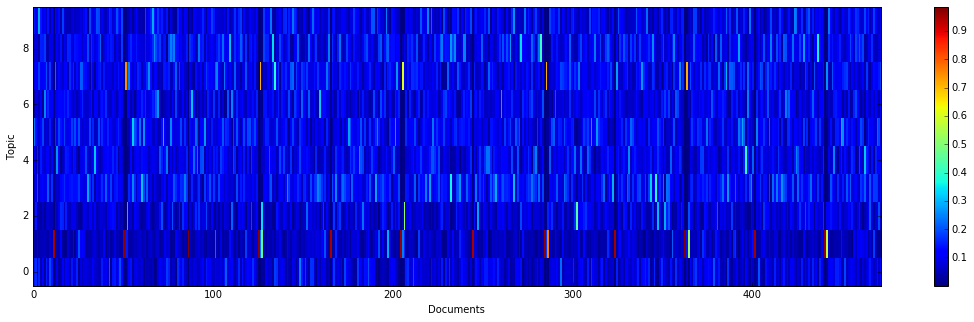

Iter 19, p=-5211972.67
Iter 20, p=-5204513.82
Iter 21, p=-5197819.00
Iter 22, p=-5191105.47
Iter 23, p=-5184544.63
Iter 24, p=-5178054.23
Iter 25, p=-5170303.06
Iter 26, p=-5165545.97
Iter 27, p=-5160248.12
Iter 28, p=-5154449.21
Iter 29, p=-5150454.31
Iter 30, p=-5144736.13
Iter 31, p=-5139016.16
Iter 32, p=-5133861.31
Iter 33, p=-5128607.36
Iter 34, p=-5125095.93
Iter 35, p=-5121963.51
Iter 36, p=-5120308.17
Iter 37, p=-5118063.12
Iter 38, p=-5116979.16


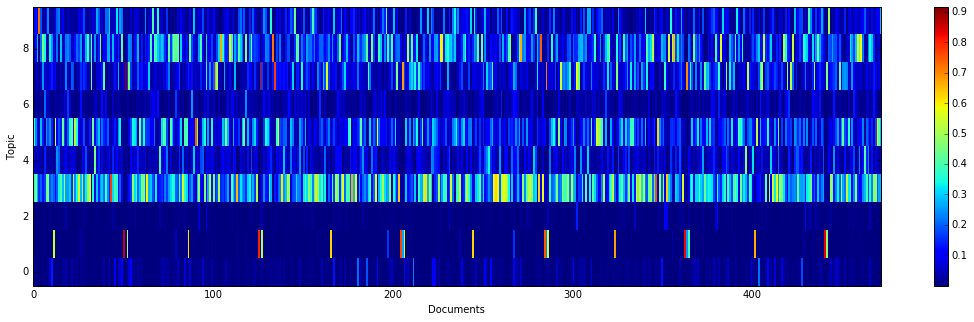

Iter 39, p=-5115458.22
Iter 40, p=-5114168.30
Iter 41, p=-5113420.23
Iter 42, p=-5112365.99
Iter 43, p=-5113201.87
Iter 44, p=-5113887.80
Iter 45, p=-5113116.27
Iter 46, p=-5113511.21
Iter 47, p=-5113167.05
Iter 48, p=-5112863.20
Iter 49, p=-5112814.44
Iter 50, p=-5113064.11
Iter 51, p=-5113185.79
Iter 52, p=-5114867.37
Iter 53, p=-5114798.95
Iter 54, p=-5115713.35
Iter 55, p=-5117248.69
Iter 56, p=-5120324.38
Iter 57, p=-5121068.56
Iter 58, p=-5122217.53


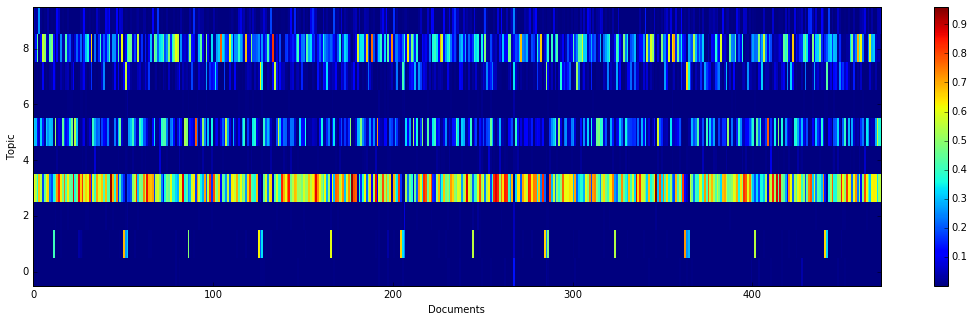

Iter 59, p=-5125039.81
Iter 60, p=-5125669.12
Iter 61, p=-5126224.49
Iter 62, p=-5130360.34
Iter 63, p=-5131559.66
Iter 64, p=-5134514.28
Iter 65, p=-5136567.91
Iter 66, p=-5139267.67
Iter 67, p=-5141878.05
Iter 68, p=-5144453.19
Iter 69, p=-5147429.30
Iter 70, p=-5150376.77
Iter 71, p=-5151917.04
Iter 72, p=-5154191.04
Iter 73, p=-5156916.08
Iter 74, p=-5158707.39
Iter 75, p=-5160231.12
Iter 76, p=-5161132.28
Iter 77, p=-5163314.78
Iter 78, p=-5164864.71


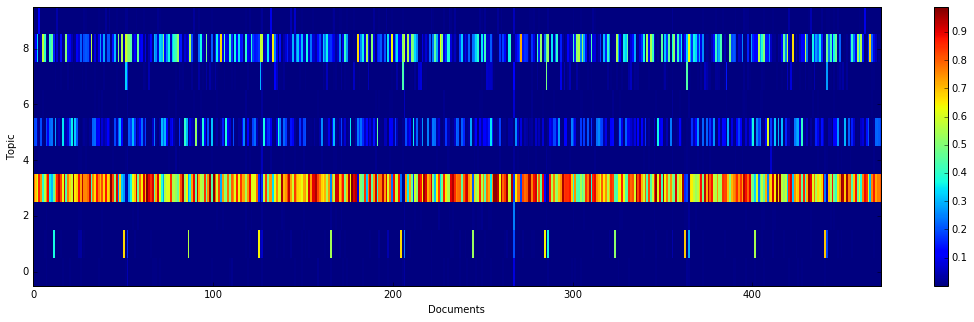

Iter 79, p=-5165023.50
Iter 80, p=-5166916.55
Iter 81, p=-5167920.99
Iter 82, p=-5169799.14
Iter 83, p=-5171789.94
Iter 84, p=-5172797.87
Iter 85, p=-5172712.03
Iter 86, p=-5172947.63
Iter 87, p=-5174919.96
Iter 88, p=-5173986.65
Iter 89, p=-5174690.25
Iter 90, p=-5174157.99
Iter 91, p=-5175072.80
Iter 92, p=-5175449.12
Iter 93, p=-5175350.01
Iter 94, p=-5175803.78
Iter 95, p=-5176786.69
Iter 96, p=-5177598.20
Iter 97, p=-5178962.84
Iter 98, p=-5179514.51


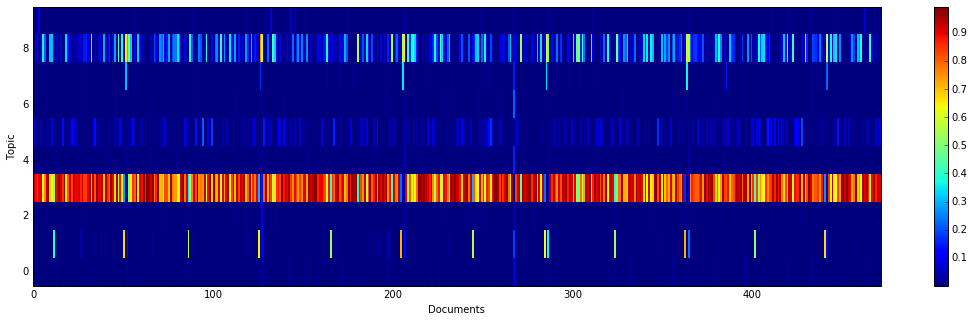

Iter 99, p=-5181476.82


In [9]:
# ======================================================================
# RUN LDA WITH GIBBS SAMPLING
# ======================================================================

#topic mixture
#qs = randomly_assign_topics( docs_i, K ) # List[lists] 472
 
alphas = np.ones((K,1))[:,0] # (10,)
gammas = np.ones((V,1))[:,0] # (17675,) # vocab size

# topic distributions
topics = np.zeros((V,K)) # (17675, 10) #for each word how likely is it that belongs to topic K
pdtm = np.zeros((K,D))  # (10, 472)

#init Topics
for i in range(0,len(topics),1):
    for j in range (0,len(topics[i]),1):
        topics[i,j] = random.uniform(0.0, 1.0)
        
#Init pdtm       
# per-document-topic distributions
for i in range(0,len(pdtm),1):
    for j in range (0, len(pdtm[i]),1):
        pdtm[i][j] = random.uniform(0.0, 1.0)
        
""
#newPdtm = None
#newTopics = None


TotalIterations = 100
ps1 = []
        
for iters in range(0,TotalIterations):
   
    #print '\r', iters, '/', TotalIterations, 
    
    Cik = genCIK(civk) #; print 'CIK: ', Cik.shape
    Cvk = genCVK(civk) #; print 'CVK: ', Cvk.shape
    
    # resample per-document topic mixtures pdtm
    pdtm = resamplePdtm(Cik,alphas) # ; print 'new pdtm: ', newPdtm.shape
    
    # resample topics
    topics = resampleTopics(Cvk,gammas) # ; print 'new topics: ', newTopics.shape
    
    # resample per-word topic assignments qs
    qs =  resample_qs(qs, topics, pdtm)
    
    if ((iters + 1) % 20 == 0) or (iters == 0):
        visualizePDTM(pdtm)
        
    p = compute_data_likelihood( docs_i, qs, topics, pdtm )
    ps1.append(p)
    print "Iter %d, p=%.2f" % (iters,p)
    


#Collapsed Gibbs Sampling

In [11]:
# ======================================================================
#INITIALIZE COLLAPSED GIBBS
# ======================================================================


#Initialize civk
Isize = D #docs
Vsize = V #vocabulary
Ksize = K #topic size
civk = np.zeros((Isize,Vsize,Ksize))
cvk = None
cik = None
ck = None
print "civk shape: ", civk.shape


for i in range(0,D,1):
    for l in range(0,len(docs_i[i]),1):
        #print i, l
        k = qs[i][l] #k = topics[l][i] 
        v = docs_i[i][l]
        civk[i][v][k] += 1


#topic mixture
#qs = randomly_assign_topics( docs_i, K ) # List[lists] 472
 
alphas = np.ones((K,1))[:,0] # (10,)
gammas = np.ones((V,1))[:,0] # (17675,) # vocab size

# topic distributions
topics = np.zeros((V,K)) # (17675, 10) #for each word how likely is it that belongs to topic K
pdtm = np.zeros((K,D))  # (10, 472)

#init Topics
for i in range(0,len(topics),1):
    for j in range (0,len(topics[i]),1):
        topics[i,j] = random.uniform(0.0, 1.0)
        
#Init pdtm       
# per-document-topic distributions
for i in range(0,len(pdtm),1):
    for j in range (0, len(pdtm[i]),1):
        pdtm[i][j] = random.uniform(0.0, 1.0)
        

civk shape:  (472, 17675, 10)


In [12]:
def resample_qs_collapsed_gibbs(qs, topics, pdtm):
    #create ck, etc....
    
    for i, doc in enumerate(docs_i):
        for l, v in enumerate(doc):
            
            tmp = []
            prev = qs[i][l]
            
            cvk[v,prev] -= 1
            ck[prev] -= 1
            cik[i,prev] -= 1
            
            Li = len(docs_i[i])
            
            # Make two fractions
            fraction1 = (cvk[v] + gammas[v]) / (ck + V * gammas[v])
            fraction2 = (cik[i] + alphas)  / (Li + (K * alphas))
            
            tmp = fraction1 * fraction2 # should be 10x1 
    
            # normalize probabilities so they sum to 1
            tmp = np.array(tmp)
            tmp = tmp / (float)(np.sum(tmp))
            
            # choose one of the topics using the probabilities
            qs[i][l] = np.random.choice(K, p = tmp)
            
            # update counts
            civk[i, docs_i[i][l], prev] -= 1
            civk[i, docs_i[i][l], qs[i][l]] += 1
            
            cvk[v,qs[i][l]] += 1
            ck[qs[i][l]] += 1
            cik[i,qs[i][l]] += 1    
            
    return qs

Iter 0, p=-805039.12


/Users/jacobbrewer/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/jacobbrewer/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:29: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


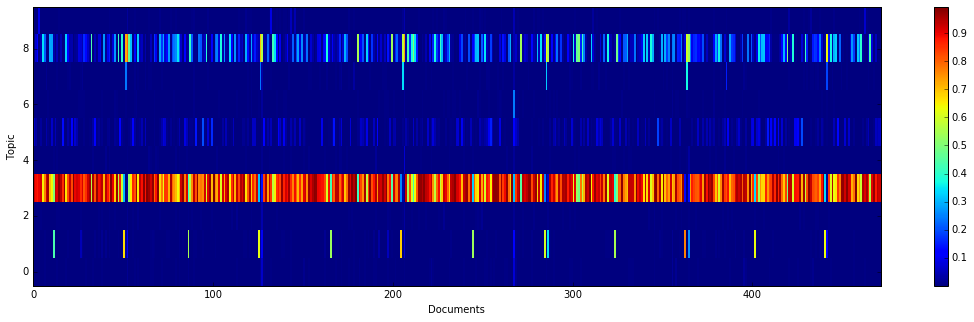

Iter 1, p=-5209150.20
Iter 2, p=-5211110.76
Iter 3, p=-5214310.92
Iter 4, p=-5217226.13
Iter 5, p=-5219044.72
Iter 6, p=-5219742.47
Iter 7, p=-5221749.57
Iter 8, p=-5224167.41
Iter 9, p=-5225598.12


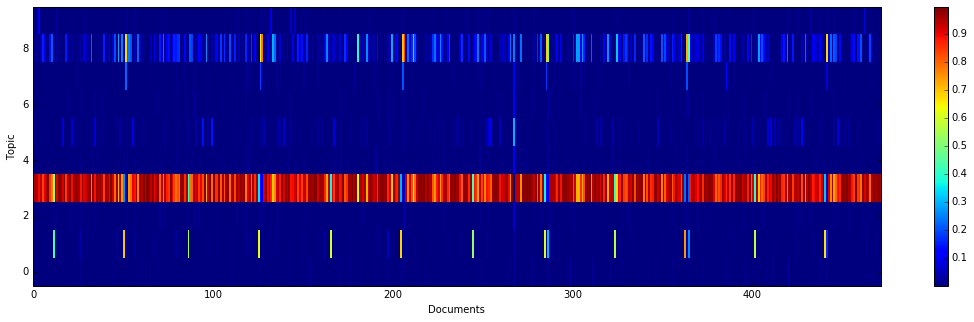

Iter 10, p=-5227746.10
Iter 11, p=-5230442.83
Iter 12, p=-5230742.86
Iter 13, p=-5233272.10
Iter 14, p=-5235545.11
Iter 15, p=-5237301.69
Iter 16, p=-5240600.82
Iter 17, p=-5243311.33
Iter 18, p=-5246478.29
Iter 19, p=-5247658.60


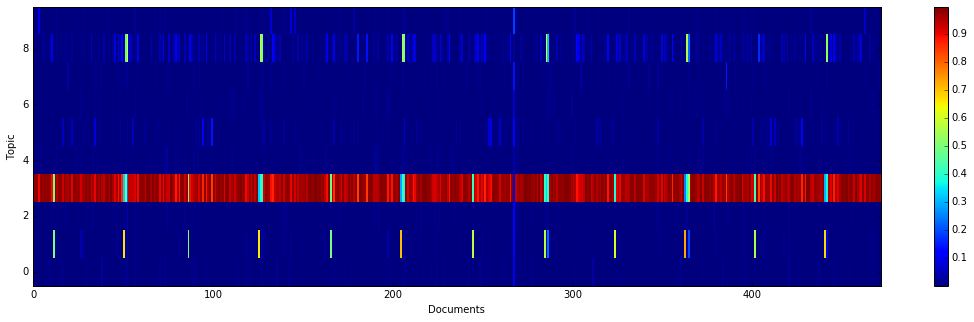

Iter 20, p=-5249786.72
Iter 21, p=-5252376.82
Iter 22, p=-5253707.64
Iter 23, p=-5254147.41
Iter 24, p=-5256659.73
Iter 25, p=-5258077.48
Iter 26, p=-5259090.06
Iter 27, p=-5258870.53
Iter 28, p=-5259765.02
Iter 29, p=-5260330.85


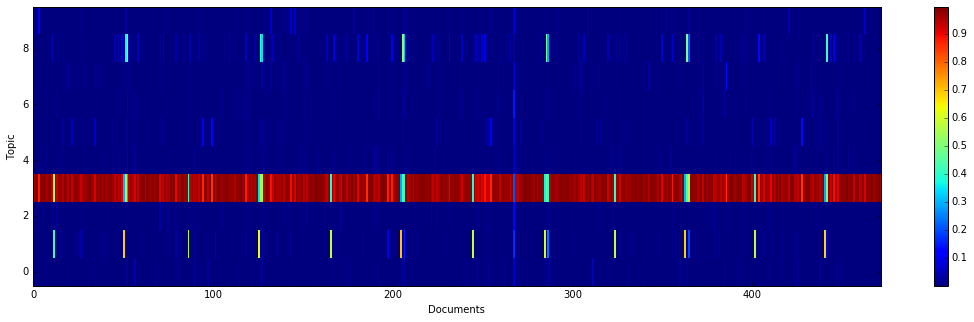

Iter 30, p=-5261073.10
Iter 31, p=-5260983.81
Iter 32, p=-5261807.94
Iter 33, p=-5262351.72
Iter 34, p=-5263025.03
Iter 35, p=-5262464.24
Iter 36, p=-5263069.56
Iter 37, p=-5263506.24
Iter 38, p=-5263817.59
Iter 39, p=-5263742.15


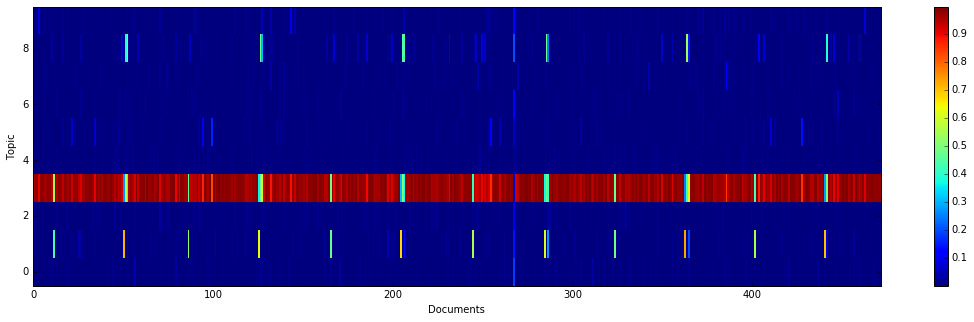

Iter 40, p=-5263767.66
Iter 41, p=-5263420.96
Iter 42, p=-5264344.37
Iter 43, p=-5264167.93
Iter 44, p=-5264990.20
Iter 45, p=-5265467.04
Iter 46, p=-5265038.41
Iter 47, p=-5265024.96
Iter 48, p=-5265596.72
Iter 49, p=-5265803.92


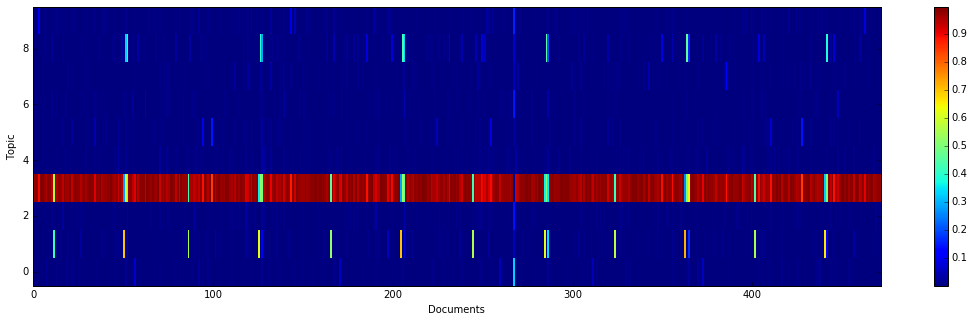

Iter 50, p=-5265248.44
Iter 51, p=-5265197.11
Iter 52, p=-5264701.12
Iter 53, p=-5265479.66
Iter 54, p=-5265585.28
Iter 55, p=-5264936.50
Iter 56, p=-5265846.64
Iter 57, p=-5265688.01
Iter 58, p=-5265595.06
Iter 59, p=-5265776.40


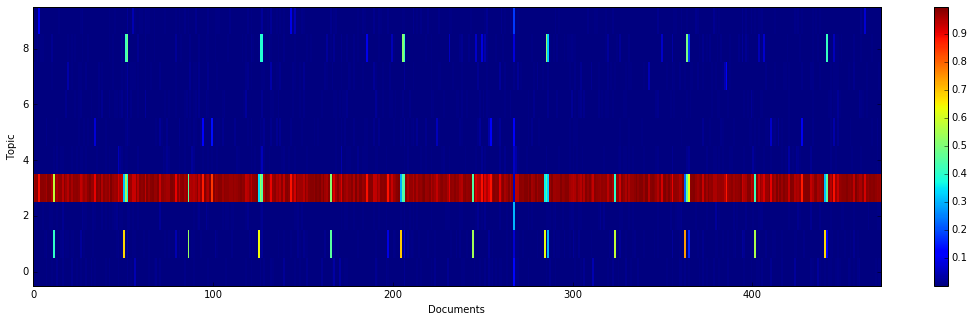

Iter 60, p=-5265182.66
Iter 61, p=-5264894.71
Iter 62, p=-5264427.60
Iter 63, p=-5266358.53
Iter 64, p=-5266105.21
Iter 65, p=-5266387.84
Iter 66, p=-5266123.23
Iter 67, p=-5266219.23
Iter 68, p=-5265845.60
Iter 69, p=-5265451.29


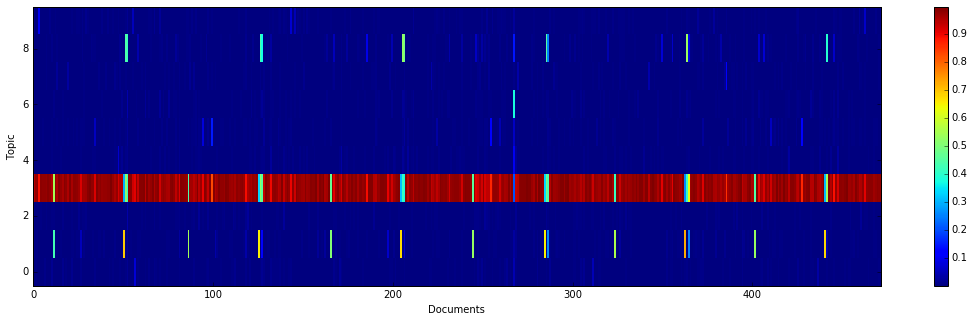

Iter 70, p=-5265828.15
Iter 71, p=-5265313.08
Iter 72, p=-5265168.39
Iter 73, p=-5265002.77
Iter 74, p=-5265003.36
Iter 75, p=-5265573.13
Iter 76, p=-5265671.89
Iter 77, p=-5266349.58
Iter 78, p=-5266096.70
Iter 79, p=-5266276.29


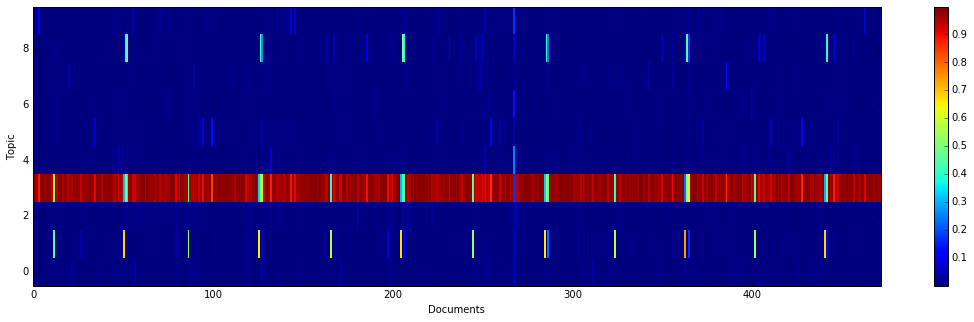

Iter 80, p=-5265759.23
Iter 81, p=-5266081.31
Iter 82, p=-5265740.35
Iter 83, p=-5265615.57
Iter 84, p=-5265203.15
Iter 85, p=-5265907.96
Iter 86, p=-5266040.28
Iter 87, p=-5266192.20
Iter 88, p=-5265991.45
Iter 89, p=-5265740.96


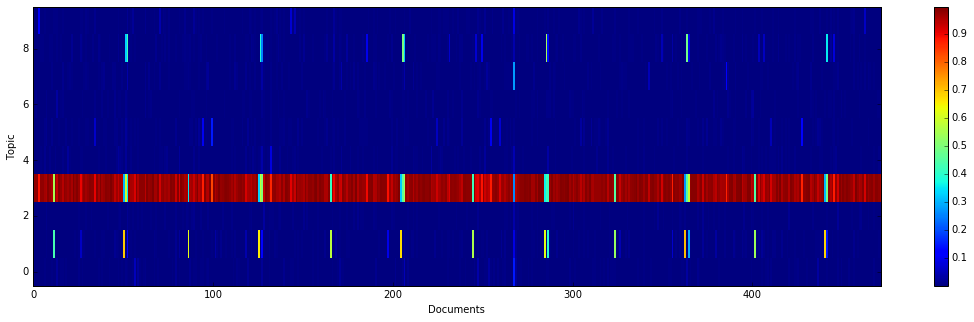

Iter 90, p=-5265411.02
Iter 91, p=-5265766.87
Iter 92, p=-5265863.86
Iter 93, p=-5265471.31
Iter 94, p=-5265501.70
Iter 95, p=-5265321.27
Iter 96, p=-5265309.79
Iter 97, p=-5264950.70
Iter 98, p=-5265695.91
Iter 99, p=-5265632.82


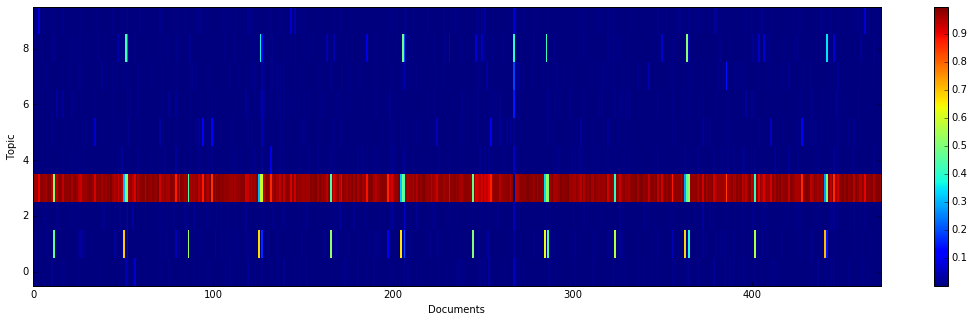

In [13]:
# ======================================================================
#RUN COLLAPSED GIBS SAMPLING
# ======================================================================

TotalIterations = 100
psCollapsed = []
        
for iters in range(0,TotalIterations):
    p = compute_data_likelihood( docs_i, qs, topics, pdtm )
    psCollapsed.append(p)
    print "Iter %d, p=%.2f" % (iters,p)
    #print '\r', iters, '/', TotalIterations, 
    
    cik = genCIK(civk) #; print 'CIK: ', Cik.shape
    cvk = genCVK(civk) #; print 'CVK: ', Cvk.shape
    ck = ck = np.sum(civk, axis = (0,1))
    
    # resample per-document topic mixtures pdtm
    pdtm = resamplePdtm(cik,alphas) # ; print 'new pdtm: ', newPdtm.shape
    
    # resample topics
    topics = resampleTopics(cvk,gammas) # ; print 'new topics: ', newTopics.shape
    
    # resample per-word topic assignments qs
    qs =  resample_qs_collapsed_gibbs(qs, topics, pdtm)
    
    if ((iters + 1) % 10 == 0) or (iters == 0):
        visualizePDTM(pdtm)
    

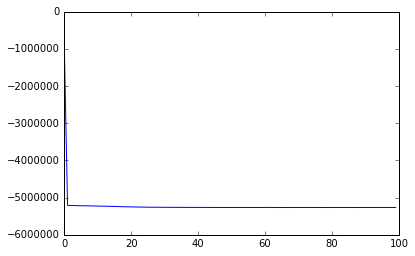

In [14]:
#visualize Probabilities
#Note the probability starts at higher value because of the initialization
plt.plot(psCollapsed)
plt.show()

In [15]:
#Get Top Words For Each Topic

top20WordsForEachTopic = []
for topicIndex in range (0,K,1): 
    top20Words = sorted(range(len(topics[:,topicIndex])), key=lambda i: topics[:,topicIndex][i])[-20:]
    top20WordsForEachTopic.append(top20Words)
    
def printTopWords(topWords):
    for index in topWords:
        print vindhash[index]       

In [26]:
print 'Top 20 words for topic 4'
"""
It appears that this topic is the topic of sustaining of church leaders since it has words such as
'opposed', 'favor', 'manifest', 'proposed' etc.
"""
printTopWords(top20WordsForEachTopic[4])

print top 20 words for topic 4
seventy
those
m
counselor
church
any
r
opposed
general
quorum
l
sustain
favor
proposed
please
as
first
presidency
manifest
it


In [27]:
print 'Top 20 words for topic 6'
"""
Topic 6 doesn't appear very frequentyly from the topics visualization. In addition to that, 
the top 20 words from this topic appear to be very random with  now real focus. It appears that
This topic must be rooted in a talk or maybe a few more that talk about the Christmas season.
It has words such as 'santa', 'snowboarders', 'bag' (maybe Santa's bag). 
"""
printTopWords(top20WordsForEachTopic[6])

Top 20 words for topic 6
disputations
sanctity
bag
stairs
gazebo
company
snowboarders
santa
dudfield
internally
birthrate
intrepid
guard
covenanting
scourgings
omniscience
films
judgmental
billions
defending


In [28]:
print 'Top 20 words for topic 3'
"""
Topic 3 appears to be contain lots of pronouns and prepositions.  
"""
printTopWords(top20WordsForEachTopic[3])

Top 20 words for topic 3
was
for
be
god
not
it
i
us
a
is
in
he
his
that
our
we
to
of
and
the


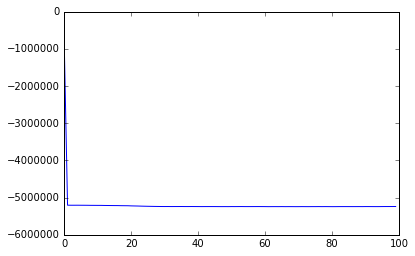

In [32]:
plt.plot(range(0,len(ps),1),ps)

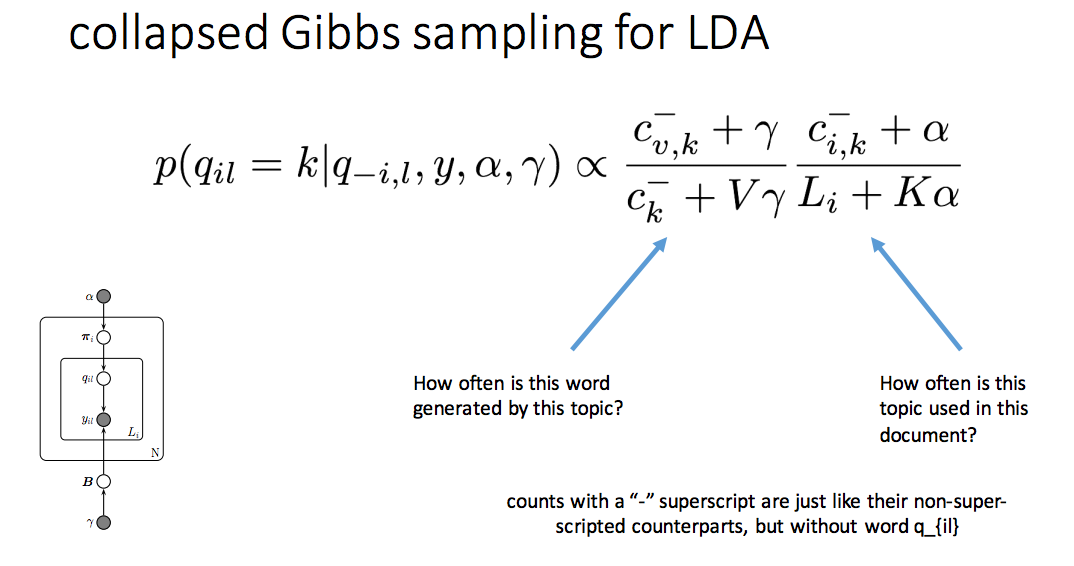

In [19]:
Image(filename='collapsed2.png')

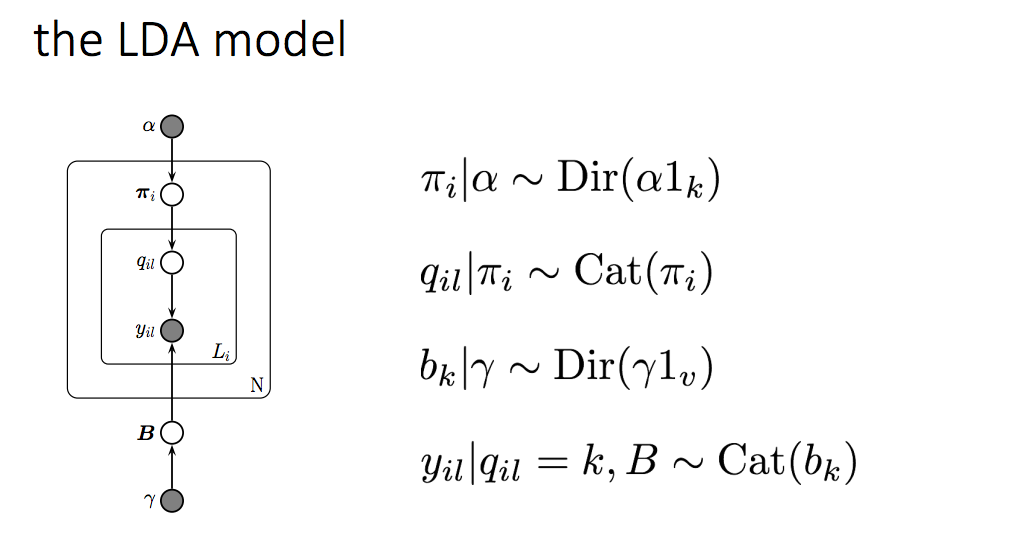

In [17]:
from IPython.display import Image
Image(filename='lda-model.png')

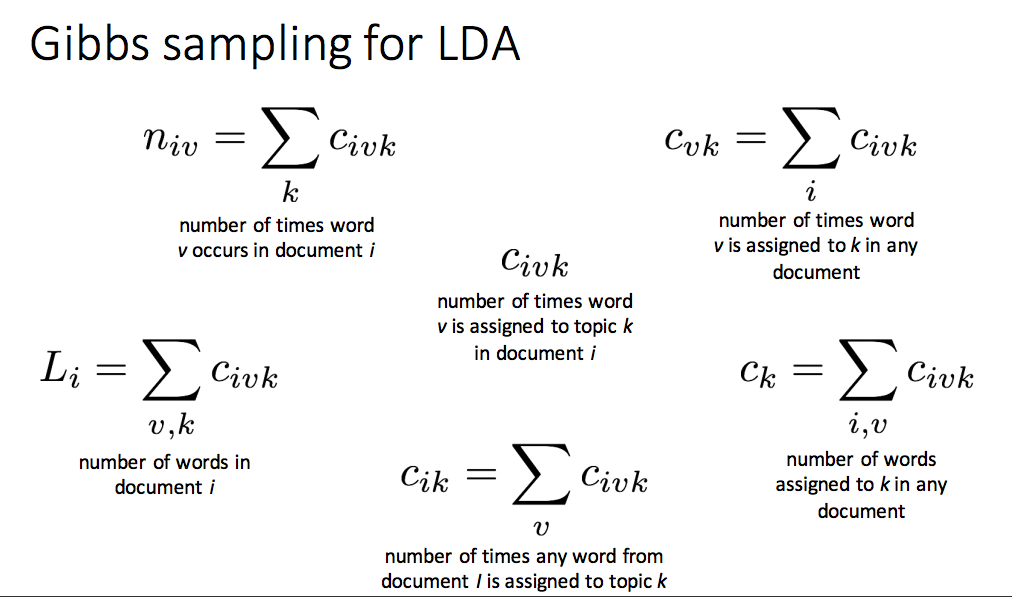

In [12]:
Image(filename='lda-model2.png')
#niv and Li should be static

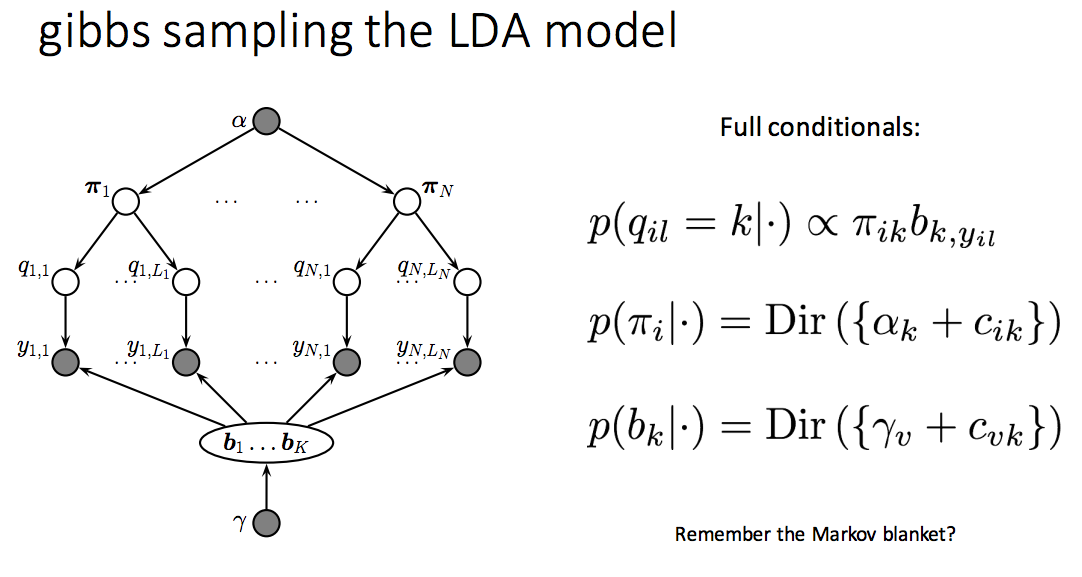

In [13]:
Image(filename='lda3.png')